## Setup

In [109]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")
fig_width = (21-5)/2.54

import poissonlearning as pl

import storage
import plotting

plotting.setup(latex=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
SAVE_PLOTS = True
NUM_PLOTTING_POINTS = 5000

### Convenience functions

In [111]:
def compute_analytic_solution(x, label_locations):
    green_first_label = pl.datasets.line.greens_function(x=x, z=label_locations[0])
    green_second_label = pl.datasets.line.greens_function(x=x, z=label_locations[1])
    solution_analytic = pd.Series(
        0.5 * green_first_label - 0.5 * green_second_label, index=x
    )
    return solution_analytic


def compute_errors(experiments):
    for experiment in experiments:
        solution = experiment["solution"]
        x = solution.index
        analytic = compute_analytic_solution(x, experiment["label_locations"])

        # For knn graphs compute the scale
        if "n_neighbors" in experiment:
            knn_scale = np.median((analytic / solution))
            solution *= knn_scale
            experiment["knn_scale"] = knn_scale
            print(f"n={experiment['n']}; n_neighbors={experiment['n_neighbors']} scale={knn_scale}")

        error_L1 = np.abs(solution - analytic).mean()
        experiment["error_L1"] = error_L1

        # Compute error to dirac experiment, if exists
        e_dirac = list(
            filter(
                lambda x: x["seed"] == experiment["seed"]
                and x["n"] == experiment["n"]
                and ((
                        "eps" in experiment
                        and "eps" in x
                        and np.isclose(x["eps"], experiment["eps"])
                    ) 
                    or (
                        "n_neighbors" in experiment
                        and "n_neighbors" in x
                        and x["n_neighbors"] == experiment["n_neighbors"]
                    )
                )
                and np.allclose(x["label_locations"], experiment["label_locations"])
                and x["kernel"] == experiment["kernel"]
                and x["bump"] == "dirac",
                experiments,
            )
        )
        if e_dirac:
            error_L1_dirac = np.abs(solution - e_dirac[0]["solution"]).mean()
            experiment["error_L1_dirac"] = error_L1_dirac


### Load experiments and compute errors

In [112]:
experiments = storage.load_results(name="line_joined", folder="../results")
compute_errors(experiments)

n=1000; n_neighbors=18 scale=0.25955360869151123
n=10000; n_neighbors=27 scale=0.09374221806895981
n=20000; n_neighbors=31 scale=0.06917625600628174
n=35000; n_neighbors=33 scale=0.04766503251154414
n=50000; n_neighbors=35 scale=0.04008524953447433
n=70000; n_neighbors=37 scale=0.03378735536262417
n=100000; n_neighbors=39 scale=0.02751077100166379
n=1000; n_neighbors=18 scale=0.2919379445640063
n=10000; n_neighbors=27 scale=0.09153842742857426
n=20000; n_neighbors=31 scale=0.0701517380873433
n=35000; n_neighbors=33 scale=0.0483316035219747
n=50000; n_neighbors=35 scale=0.040526627246996065
n=70000; n_neighbors=37 scale=0.03417387373432719
n=100000; n_neighbors=39 scale=0.028055517339546313
n=1000; n_neighbors=18 scale=0.25463423695577597
n=10000; n_neighbors=27 scale=0.09460737734594334
n=20000; n_neighbors=31 scale=0.06961784325783138
n=35000; n_neighbors=33 scale=0.04898263313634474
n=50000; n_neighbors=35 scale=0.04049410912637797
n=70000; n_neighbors=37 scale=0.034107735220229515
n

## Plotting

### Convergence of dirac solutions

In [113]:
kernel = "uniform"
selected_experiments = {
    f"n={n}": list(
        filter(
            lambda x: x["kernel"] == kernel
            and x["bump"] == "dirac"
            and x["n"] == n
            and "eps" in x,
            experiments,
        )
    )[2]
    for n in [10000, 20000, 50000, 100000]
}
solution_analytic = compute_analytic_solution(np.linspace(0, 1, NUM_PLOTTING_POINTS * 3), experiments[0]["label_locations"])

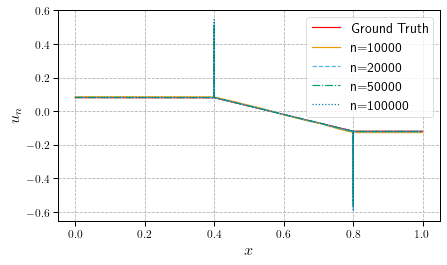

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.6*fig_width))
ax.set_prop_cycle(plotting.line_cycler)
plotting.results_1D(
    selected_experiments,
    ax=ax,
    truth=solution_analytic,
    num_plotting_points=NUM_PLOTTING_POINTS,
)

# ax_dirac.set_title(f"Convergence of Dirac RHS with kernel '{kernel}'")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u_n$")
ax.legend()
ax.grid(linestyle="dashed")
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../plots/line_demo.pdf", bbox_inches="tight")

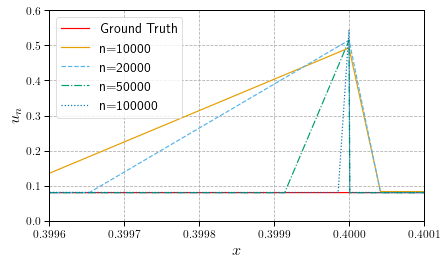

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.6*fig_width))
ax.set_prop_cycle(plotting.line_cycler)
plotting.results_1D(
    selected_experiments,
    ax=ax,
    truth=solution_analytic,
    num_plotting_points=NUM_PLOTTING_POINTS * 3,
)

# ax_dirac.set_title(f"Convergence of Dirac RHS with kernel '{kernel}'")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u_n$")
ax.legend()
ax.grid(linestyle="dashed")
ax.set_xlim(0.39960, 0.40010)
ax.set_ylim(0.0, 0.6)
ax.set_xticks(np.linspace(0.39960, 0.40010, 6))
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../plots/line_demo_zoom.pdf", bbox_inches="tight")

In [116]:
ex = selected_experiments["n=100000"]
s = ex["solution"]
s.loc[(s.index >= 0.39995) & (s.index <= 0.40005)]

0.399976    0.080272
0.399985    0.080272
0.400000    0.544929
0.400001    0.080270
0.400017    0.080269
0.400022    0.080268
0.400027    0.080268
0.400042    0.080261
dtype: float64

### Convergence of bumps

In [117]:
n = 100000
kernel = "gaussian"
selected_experiments = {
    f"bump width={bump}": list(
        filter(
            lambda x: 
                x["kernel"] == kernel and 
                x["bump"] == bump and 
                x["n"] == n 
                and "eps" in x,
            experiments,
        )
    )[0]
    for bump in ["dirac", 0.001, 0.01, 0.02]
}

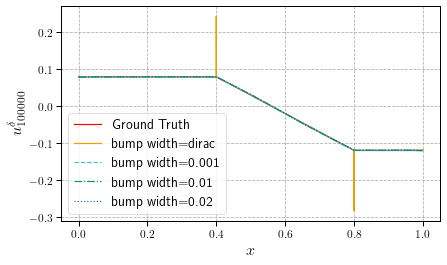

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.6*fig_width))
ax.set_prop_cycle(plotting.line_cycler)
plotting.results_1D(
    selected_experiments,
    ax=ax,
    truth=solution_analytic,
    num_plotting_points=NUM_PLOTTING_POINTS,
)
# ax.set_title(f"Convergence of smoothed RHS with kernel '{kernel}', n={n}")
ax.set_xlabel(r"$x$")
ax.set_ylabel(fr"$u_{ {n} }^\delta$")
ax.legend()
ax.grid(linestyle="dashed")
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../plots/line_delta.pdf", bbox_inches="tight")

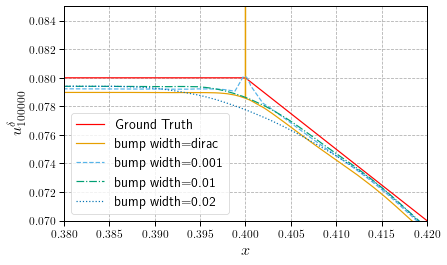

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.6*fig_width))
ax.set_prop_cycle(plotting.line_cycler)
plotting.results_1D(
    selected_experiments,
    ax=ax,
    truth=solution_analytic,
    num_plotting_points=NUM_PLOTTING_POINTS,
)
# ax.set_title(f"Convergence of smoothed RHS with kernel '{kernel}', n={n}")
ax.set_xlabel(r"$x$")
ax.set_ylabel(fr"$u_{ {n} }^\delta$")
ax.legend()
ax.grid(linestyle="dashed")
ax.set_xlim(0.38, 0.42)
ax.set_ylim(0.07, 0.085)
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../plots/line_delta_zoom.pdf", bbox_inches="tight")

### Errors for dirac solutions

In [131]:
selected_experiments = {
    f"kernel={kernel}": list(
        filter(
            lambda x: 
                x["kernel"] == kernel 
                and x["bump"] == "dirac"
                and "eps" in x,
                experiments,
        )
    )
    for kernel in ["uniform", "gaussian"]
}
n_error = sorted(list(set([e["n"] for e in list(selected_experiments.values())[0]])))
error = {kernel: {} for kernel in selected_experiments.keys()}
for kernel, experiments_with_kernel in selected_experiments.items():
    for n in n_error:
        ex = list(filter(lambda x: x["n"] == n, experiments_with_kernel))
        error[kernel][n] = {}
        error[kernel][n]["mean"] = np.mean([e["error_L1"] for e in ex])
        error[kernel][n]["max"] = np.max([e["error_L1"] for e in ex])
        error[kernel][n]["min"] = np.min([e["error_L1"] for e in ex])
        print("Number of trials: ", len(ex))

Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10
Number of trials:  10


2022-10-04 19:54:53 INFO:plotting   Fitted parameters: [0.23751369 0.48547602]
2022-10-04 19:54:54 INFO:plotting   Fitted parameters: [0.22024458 0.47169261]


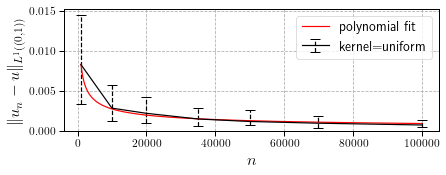

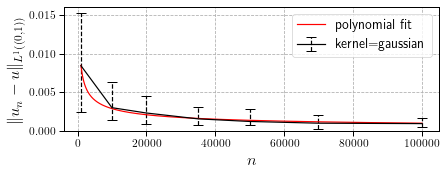

In [132]:
for kernel, e in error.items():
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.4*fig_width))
    plotting.error_plot({kernel: e}, ax, fit="polynomial", c="black")

    # ax.set_xscale("log")
    # ax.set_title("L1 error of solution with dirac RHS")
    ax.legend()
    ax.set_xlabel(r"$n$")
    ax.set_ylabel(r"$\lVert u_n - u \rVert_{L^1 \left((0, 1) \right)}$")
    ax.set_ylim(0.0, None)

    fig.tight_layout()
    if SAVE_PLOTS:
        fig.savefig(f"../plots/line_dirac_n_{kernel}.pdf", bbox_inches="tight")

### Errors for bump convergence

In [129]:
selected_experiments = {
    f"bump width={bump}": list(
        filter(lambda x:
            x["bump"] == bump
            and x["kernel"] == "gaussian"
            and "eps" in x,
            #and x["n"] < 100000,
            experiments,
        )
    )
    for bump in [0.001, 0.01, 0.02]
}

n_error = sorted(list(set([e["n"] for e in list(selected_experiments.values())[0]])))
error = {bump: {} for bump in selected_experiments.keys()}
for bump, experiments_with_bump in selected_experiments.items():
    for n in n_error:
        ex = list(filter(lambda x: x["n"] == n, experiments_with_bump))
        if ex:
            error[bump][n] = {}
            error_list = [e["error_L1_dirac"] for e in ex if e["error_L1_dirac"] > 0]
            error[bump][n]["mean"] = np.mean(error_list) if error_list else np.nan
            error[bump][n]["max"] = np.max(error_list) if error_list else np.nan
            error[bump][n]["min"] = np.min(error_list) if error_list else np.nan
            error[bump][n]["size"] = len(error_list) if error_list else np.nan

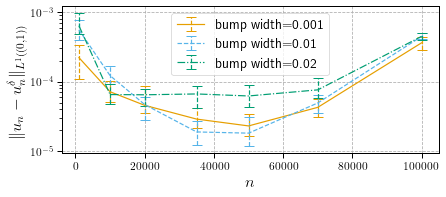

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.45*fig_width))
ax.set_prop_cycle(plotting.line_cycler)
for i, (bump, e) in enumerate(error.items()):
    plotting.error_plot({bump: e}, ax, fit=None, label=bump)

    # ax.set_xscale("log")
    # ax.set_title("L1 error of solution with dirac RHS")
ax.legend()
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lVert u_n - u_n^\delta \rVert_{L^1 \left((0, 1) \right)}$")
ax.set_yscale("log")

fig.tight_layout()
if SAVE_PLOTS:
    fig.savefig(f"../plots/line_dirac_bump_approximation.pdf", bbox_inches="tight")

### KNN Graph convergence

In [134]:
selected_experiments = {
    f"kernel={kernel}": list(
        filter(
            lambda x: 
                x["kernel"] == kernel 
                and x["bump"] == "dirac"
                and "n_neighbors" in x,
                experiments,
        )
    )
    for kernel in ["uniform"]
}
n_error = sorted(list(set([e["n"] for e in list(selected_experiments.values())[0]])))
error = {kernel: {} for kernel in selected_experiments.keys()}
for kernel, experiments_with_kernel in selected_experiments.items():
    for n in n_error:
        ex = list(filter(lambda x: x["n"] == n, experiments_with_kernel))
        if ex:
            error[kernel][n] = {}
            error[kernel][n]["mean"] = np.mean([e["error_L1"] for e in ex])
            error[kernel][n]["max"] = np.max([e["error_L1"] for e in ex])
            error[kernel][n]["min"] = np.min([e["error_L1"] for e in ex])

2022-10-04 19:55:37 INFO:plotting   Fitted parameters: [0.13425299 0.56439045]


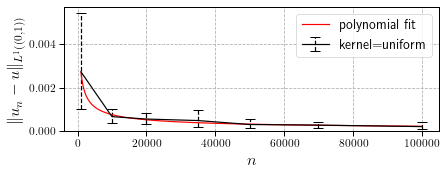

In [135]:
for kernel, e in error.items():
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.4*fig_width))
    plotting.error_plot({kernel: e}, ax, fit="polynomial", c="black")

    #ax.set_yscale("log")
    # ax.set_title("L1 error of solution with dirac RHS")
    ax.legend()
    ax.set_xlabel(r"$n$")
    ax.set_ylabel(r"$\lVert u_n - u \rVert_{L^1 \left((0, 1) \right)}$")
    ax.set_ylim(0.0, None)

    fig.tight_layout()
    if SAVE_PLOTS:
        fig.savefig(f"../plots/line_dirac_n_{kernel}_knn.pdf", bbox_inches="tight")